# SOM Component Planes and U-Matrix: Examples and Experiments

In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from minisom import MiniSom
from sklearn.preprocessing import MinMaxScaler
from src import util
from src.roi import RegionOfInterest

In [2]:
# Configure plots
import matplotlib as mpl
import matplotlib.gridspec as gridspec

# Set global matplotlib parameters
mpl.rcParams['lines.linewidth'] = 1.2
mpl.rcParams['lines.markersize'] = 6
mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 12

mpl.rcParams['axes.grid.axis'] = 'y'
mpl.rcParams['grid.alpha'] = 0.3

# Use LaTeX-friendly font
plt.rcParams['text.usetex'] = True

In [3]:
seed = 42

## Iris data

In [4]:
iris = load_iris()
X = iris.data
feature_names = iris.feature_names
target = iris.target
target_names=iris.target_names

In [5]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [6]:
training_epochs = X.shape[0]*20
map_size = (8,8)
neighborhood_init = min(map_size)*0.5
print('Number of neurons:', map_size[0]*map_size[1])
print('Training epochs:', training_epochs)
print('Map size:', map_size)

som = MiniSom(
    x=map_size[0],
    y=map_size[1],
    input_len=X.shape[1], 
    sigma=neighborhood_init,
    learning_rate=0.5,
    activation_distance='euclidean',
    neighborhood_function='gaussian',
    random_seed=seed,)

Number of neurons: 64
Training epochs: 3000
Map size: (8, 8)


In [7]:
som.pca_weights_init(X_scaled)
som.train_batch(X_scaled, training_epochs, verbose=True)
print(' topographic error:', som.topographic_error(X_scaled))

 [ 3000 / 3000 ] 100% - 0:00:00 left 
 quantization error: 0.11228796084196892
 topographic error: 0.02


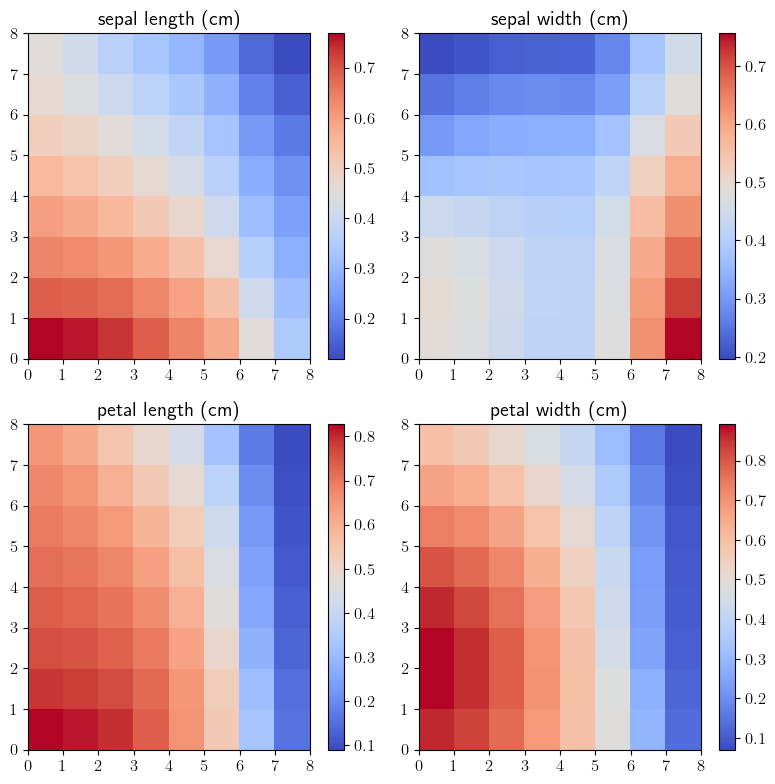

In [8]:
W = som.get_weights()

plt.figure(figsize=map_size)
for i, f in enumerate(feature_names):
    plt.subplot(2, 2, i+1)
    plt.title(f)
    plt.pcolor(W[:,:,i].T, cmap='coolwarm')
    plt.xticks(np.arange(map_size[0]+1))
    plt.yticks(np.arange(map_size[1]+1))
    plt.colorbar()
    
plt.tight_layout()

In [9]:
# Plotting the response for each pattern in the iris dataset
# different colors and markers for each label
markers = ['s', 'p', '^']
colors = ['indigo', 'darkorange', 'seagreen']

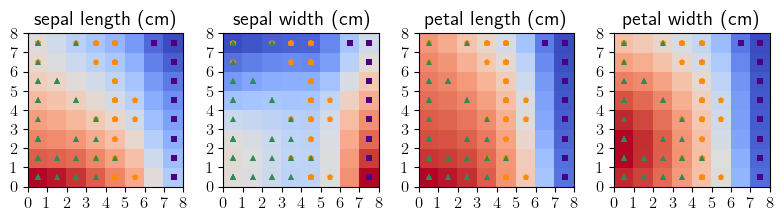

In [10]:
W = som.get_weights()

plt.figure(figsize=map_size)
for i, f in enumerate(feature_names):
    plt.subplot(4, 4, i+1)
    plt.title(f)
    plt.pcolor(W[:,:,i].T, cmap='coolwarm')
    
    for cnt, xx in enumerate(X_scaled):
        w = som.winner(xx)  # getting the winner
        # palce a marker on the winning position for the sample xx
        plt.plot(w[0]+.5, w[1]+.5, markers[target[cnt]], markerfacecolor=colors[target[cnt]],
                 markeredgecolor='black', markersize=5, markeredgewidth=0, label=target_names[target[cnt]])

    
    plt.xticks(np.arange(map_size[0]+1))
    plt.yticks(np.arange(map_size[1]+1))
    
plt.tight_layout()

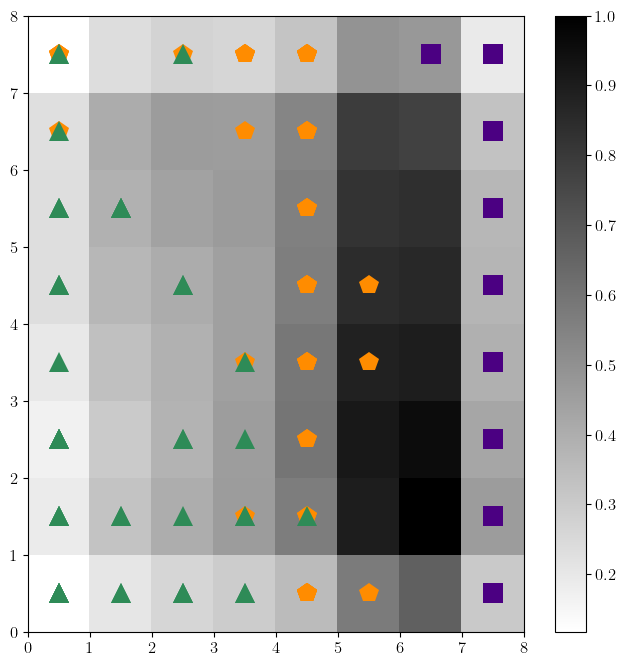

In [11]:
fig = plt.figure(figsize=map_size)
ax = fig.add_subplot(111)

plt.pcolor(som.distance_map().T, cmap='gray_r')  # plotting the distance map as background
plt.colorbar()

for cnt, xx in enumerate(X_scaled):
    w = som.winner(xx)  # getting the winner
    # palce a marker on the winning position for the sample xx
    plt.plot(w[0]+.5, w[1]+.5, markers[target[cnt]], markerfacecolor=colors[target[cnt]],
             markeredgecolor='black', markersize=15, markeredgewidth=0, label=target_names[target[cnt]])

## 1994 Census data

In [12]:
adult_dataset = pd.read_pickle(os.path.join('data', 'processed', 'adult_minmax.pkl')).reset_index(drop=True)

In [13]:
X = adult_dataset.values

In [14]:
parameters_grid = [
    {'mapsize': [(8, 8), (10, 10), (15, 10)], 
     'learning_rate':[0.1, 0.5, 0.8, 1.0], 
     'sigma':[1, 3, 5], 
     'max_training_iterations':[1000, 2000, 5000], 
     'verbose':[False]},
]

In [15]:
training_epochs = min(X.shape[0]*20, 10000)

In [16]:
map_size = util.calculate_map_size(X, 'rectangular')
neighborhood_init = min(map_size)*0.5

In [17]:
print('Number of neurons:', map_size[0]*map_size[1])
print('Training epochs:', training_epochs)
print('Map size:', map_size)

Number of neurons: 1056
Training epochs: 10000
Map size: [24, 44]


In [18]:
som = MiniSom(
    x=map_size[0],
    y=map_size[1],
    input_len=X.shape[1], 
    sigma=neighborhood_init,
    learning_rate=0.5,
    activation_distance='euclidean',
    neighborhood_function='gaussian',
    random_seed=seed,)

In [19]:
som.pca_weights_init(X)

In [20]:
som.train_batch(X, training_epochs, verbose=True)

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 1.2640662122658481


## SOM Component planes

Here we will create a map for each feature used that reflects the magnitude of the weights associated to it for each neuron.

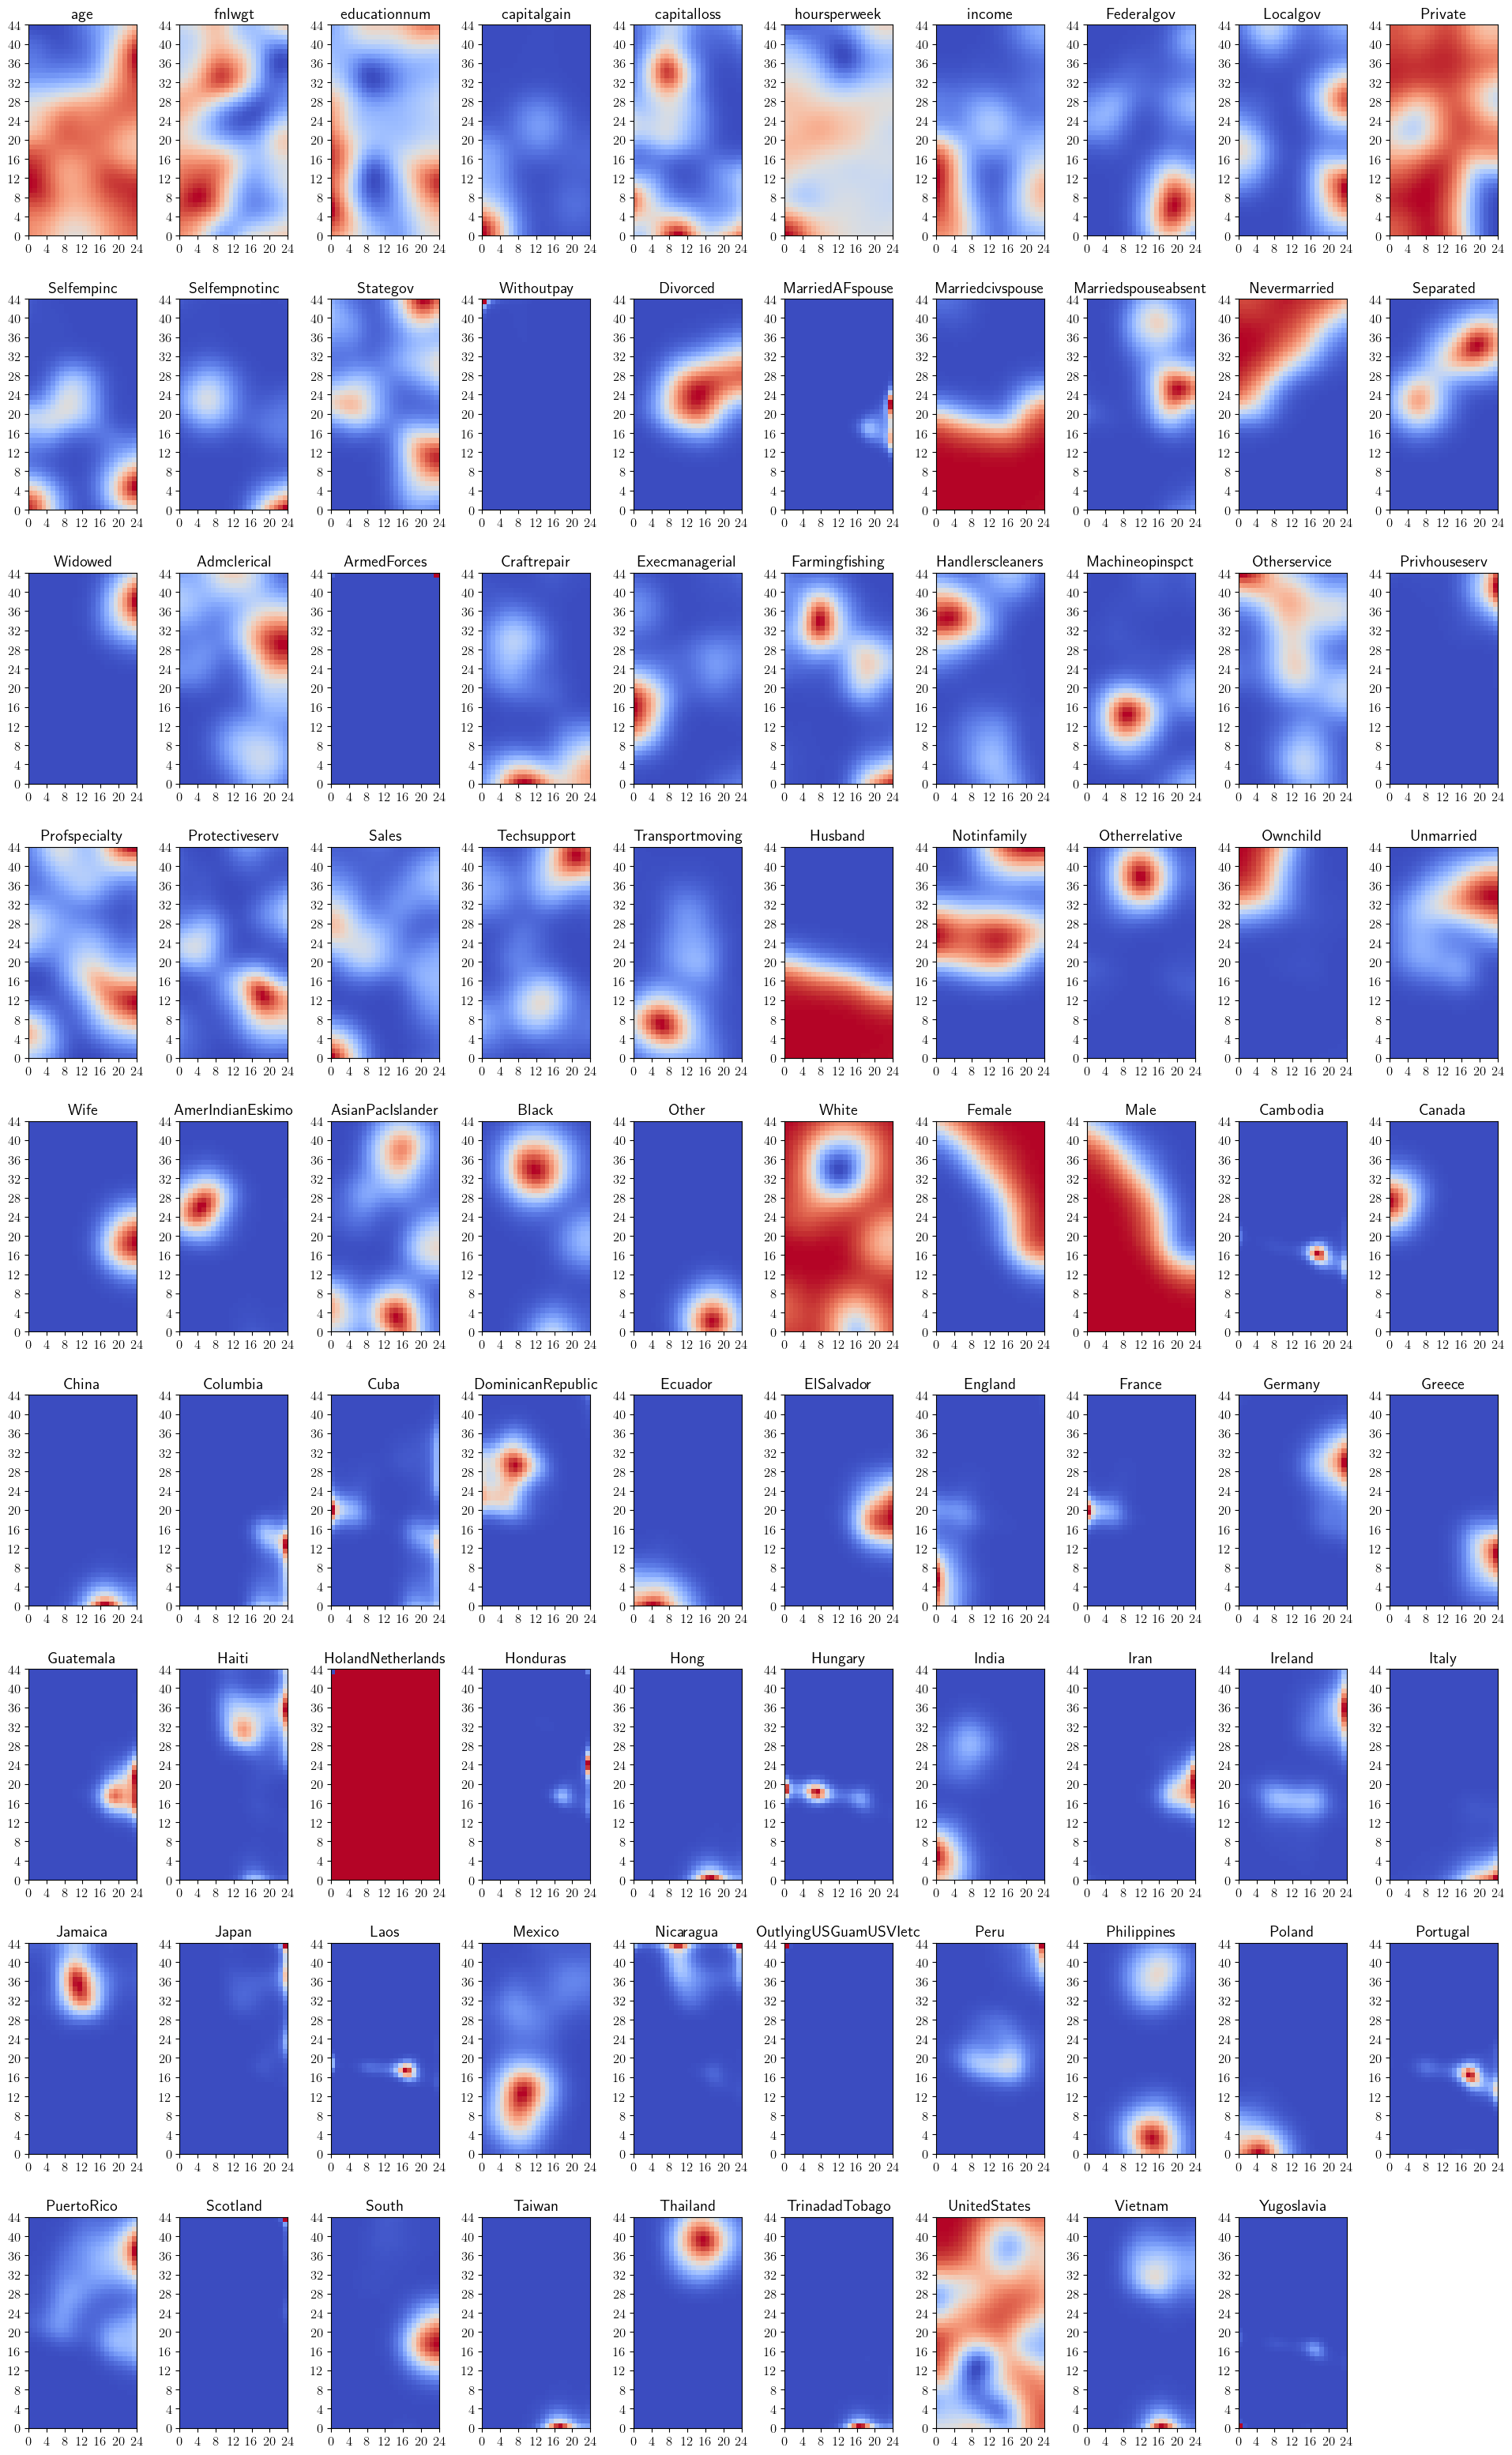

In [21]:
cols = int(np.ceil(float(X.shape[1])**0.5))
rows = cols

W = som.get_weights()
plt.figure(figsize=map_size)

for i, f in enumerate(adult_dataset.columns):
    plt.subplot(rows, cols, i+1)
    title = f
    if '_' in title:
        title = title.split('_')[-1]
    plt.title(title)
    plt.pcolor(W[:,:,i].T, cmap='coolwarm')
    plt.xticks(np.arange(0, map_size[0]+1, 4))
    plt.yticks(np.arange(0, map_size[1]+1, 4))
    
# set the spacing between subplots
plt.subplots_adjust(wspace=0.4, 
                    hspace=0.3)
plt.show()

## Group planes by similarity

In [22]:
similarity_map = util.compute_similarity(W)

In [23]:
best = dict()
for i in range(W.shape[-1]):
    if i not in best:
        original = similarity_map[i]
        topk = sorted(similarity_map[i])
        best[i] = [similarity_map[i].index(k) for k in topk[:3]][1]

In [24]:
print(best)

{0: 5, 1: 12, 2: 5, 3: 66, 4: 66, 5: 0, 6: 0, 7: 12, 8: 12, 9: 2, 10: 3, 11: 10, 12: 31, 13: 65, 14: 21, 15: 79, 16: 35, 17: 84, 18: 38, 19: 20, 20: 33, 21: 28, 22: 62, 23: 7, 24: 1, 25: 4, 26: 25, 27: 73, 28: 1, 29: 80, 30: 1, 31: 59, 32: 1, 33: 42, 34: 73, 35: 16, 36: 14, 37: 42, 38: 26, 39: 19, 40: 82, 41: 49, 42: 77, 43: 37, 44: 59, 45: 86, 46: 21, 47: 2, 48: 63, 49: 41, 50: 69, 51: 85, 52: 57, 53: 70, 54: 56, 55: 76, 56: 52, 57: 65, 58: 80, 59: 69, 60: 51, 61: 74, 62: 22, 63: 88, 64: 83, 65: 48, 66: 78, 67: 60, 68: 52, 69: 64, 70: 61, 71: 15, 72: 22, 73: 4, 74: 71, 75: 22, 76: 68, 77: 44, 78: 54, 79: 65, 80: 29, 81: 63, 82: 55, 83: 64, 84: 80, 85: 79, 86: 45, 87: 70, 88: 72}


In [25]:
# find keys with the same value
order = dict()
for k,v in best.items():
    if v not in order:
        order[v] = []
    order[v].append(k)

In [26]:
print(order)

{5: [0, 2], 12: [1, 7, 8], 66: [3, 4], 0: [5, 6], 2: [9, 47], 3: [10], 10: [11], 31: [12], 65: [13, 57, 79], 21: [14, 46], 79: [15, 85], 35: [16], 84: [17], 38: [18], 20: [19], 33: [20], 28: [21], 62: [22], 7: [23], 1: [24, 28, 30, 32], 4: [25, 73], 25: [26], 73: [27, 34], 80: [29, 58, 84], 59: [31, 44], 42: [33, 37], 16: [35], 14: [36], 26: [38], 19: [39], 82: [40], 49: [41], 77: [42], 37: [43], 86: [45], 63: [48, 81], 41: [49], 69: [50, 59], 85: [51], 57: [52], 70: [53, 87], 56: [54], 76: [55], 52: [56, 68], 51: [60], 74: [61], 22: [62, 72, 75], 88: [63], 83: [64], 48: [65], 78: [66], 60: [67], 64: [69, 83], 61: [70], 15: [71], 71: [74], 68: [76], 44: [77], 54: [78], 29: [80], 55: [82], 45: [86], 72: [88]}


In [27]:
visited = []
for k, v in order.items():
    if k not in visited:
        visited.append(k)
    for c in v:
        if c not in visited:
            visited.append(c)
len(visited)

89

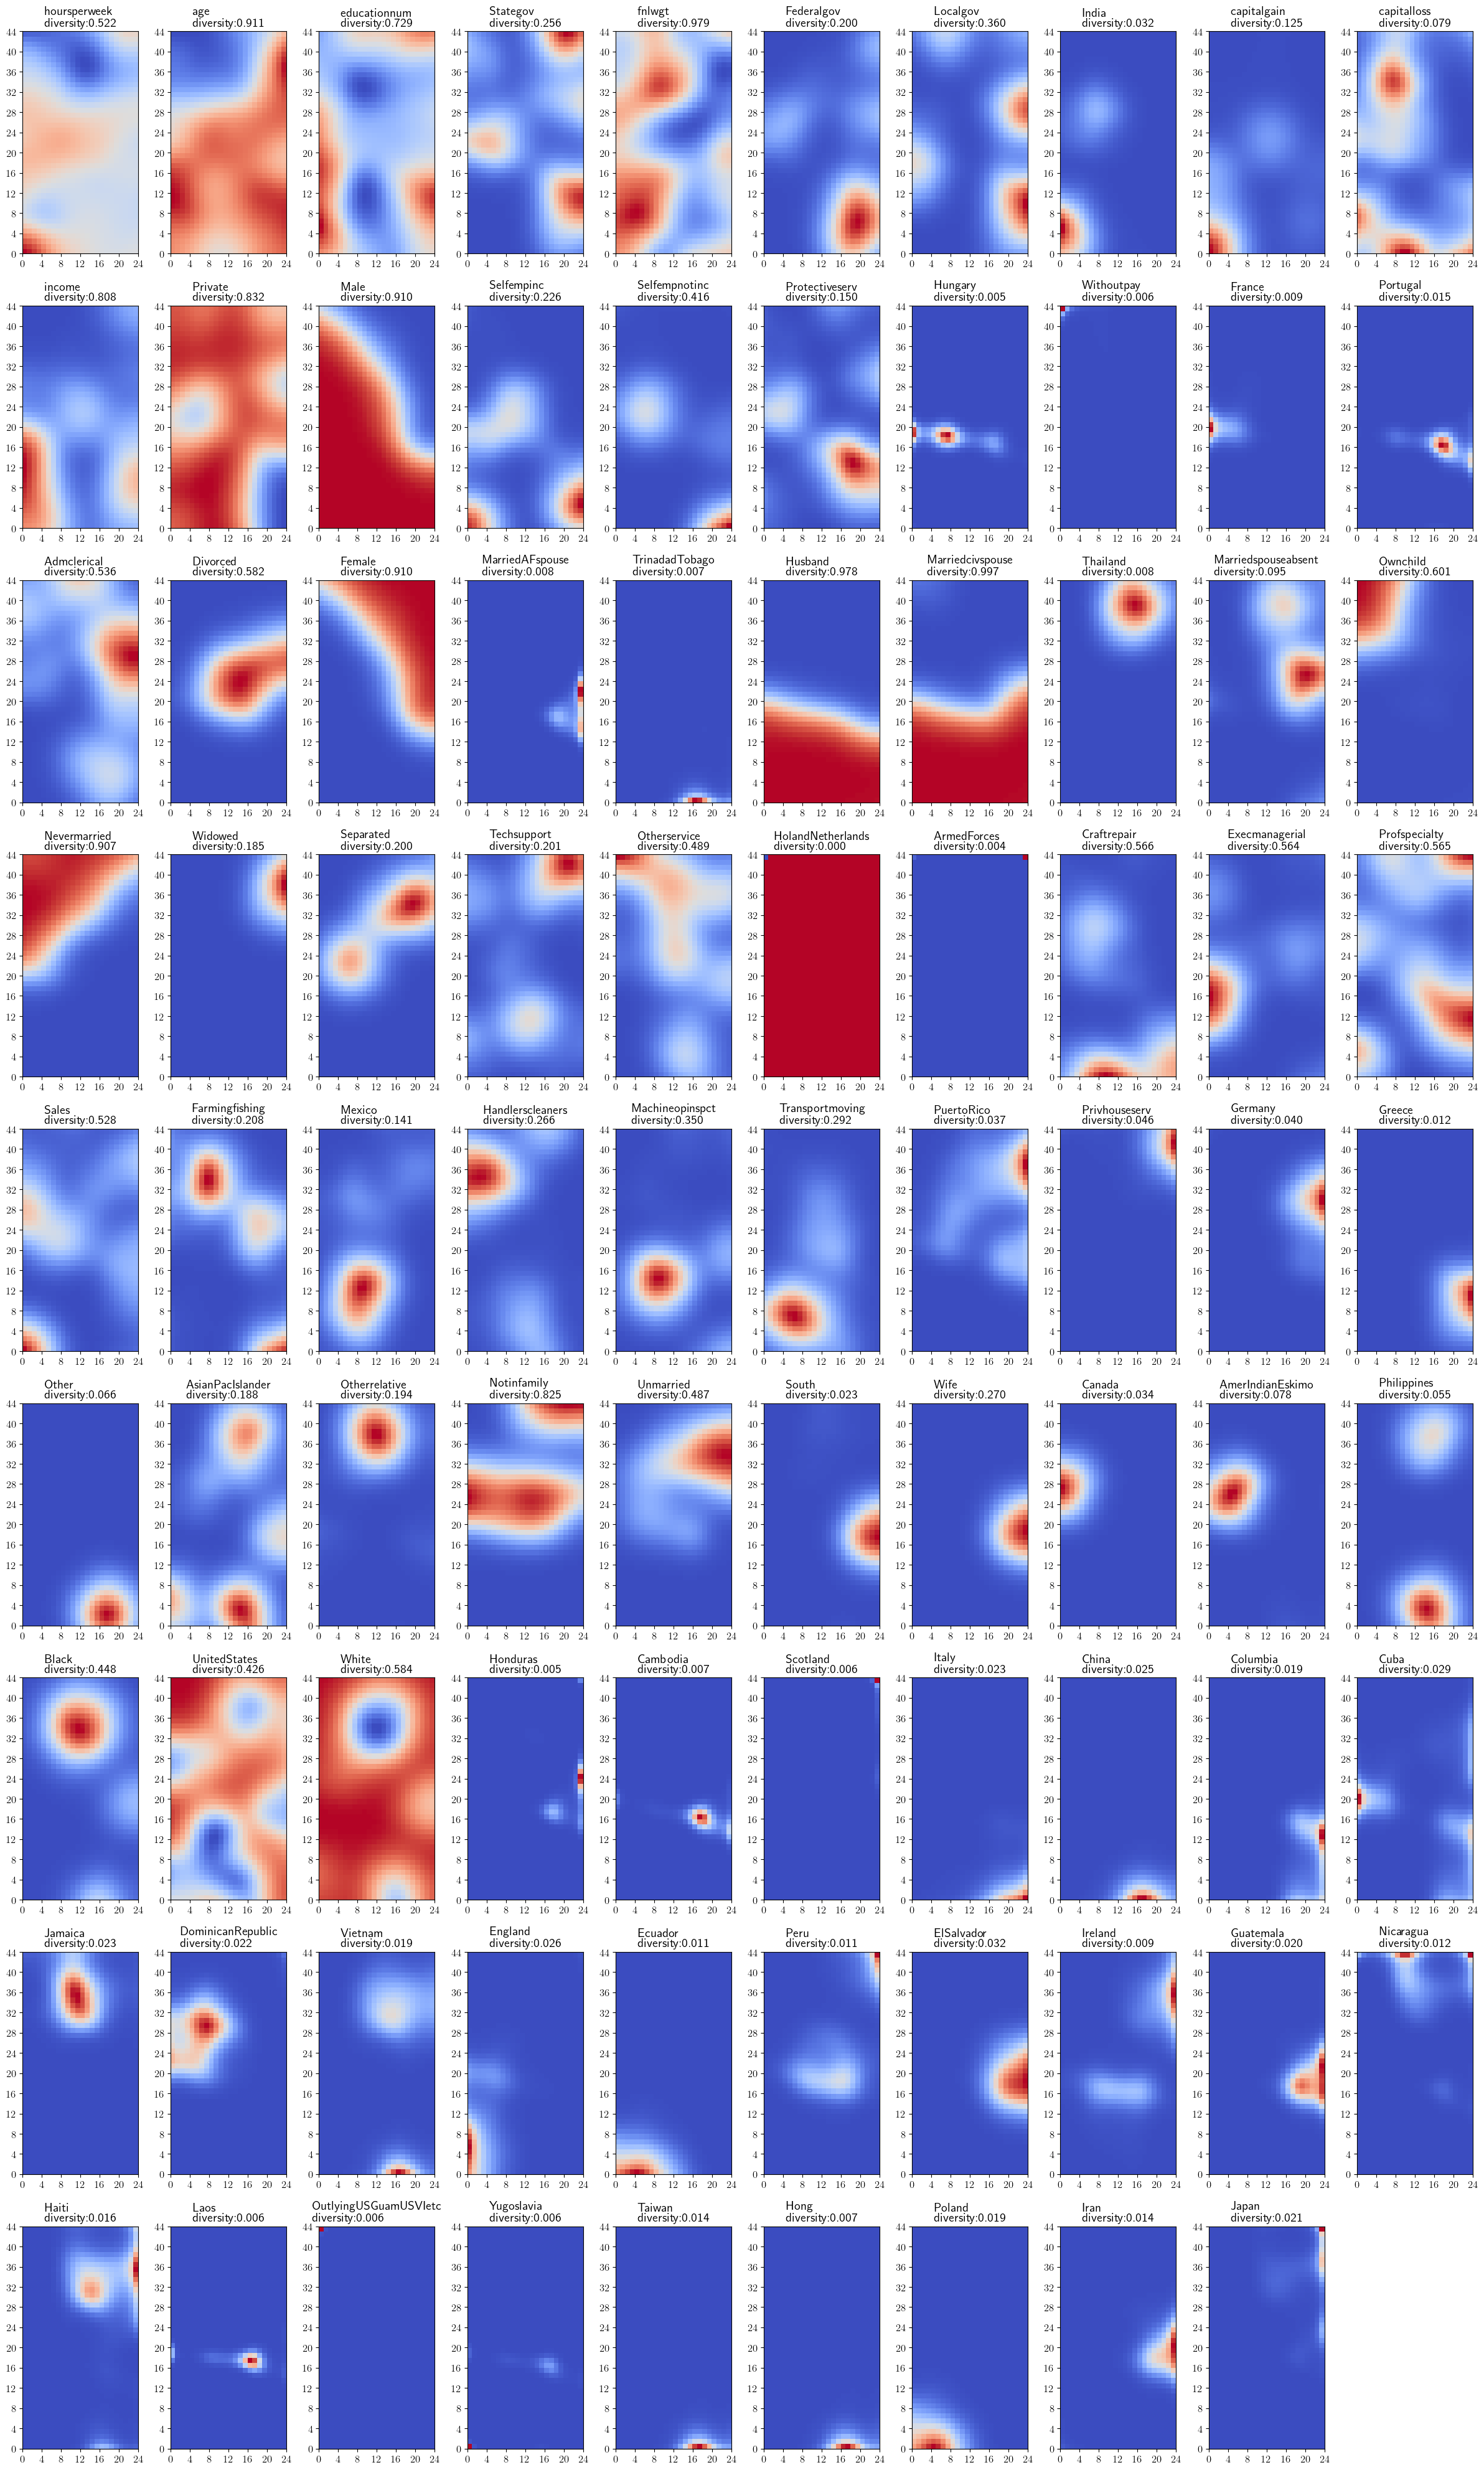

In [28]:
cols = int(np.ceil(float(X.shape[1])**0.5))
rows = cols

plt.figure(figsize=map_size)

count = 0
for i, component in enumerate(visited):
    feature = adult_dataset.columns[component]
    diversity = util.shannon_diversity(adult_dataset[feature].value_counts().values)
    title = feature
    if '_' in title:
        title = title.split('_')[-1]
    title = f'{title}\ndiversity:{diversity:.3f}'
    plt.subplot(rows, cols, i+1)
    plt.title(title)
    plt.pcolor(W[:,:,component].T, cmap='coolwarm')
    plt.xticks(np.arange(0, map_size[0]+1, 4))
    plt.yticks(np.arange(0, map_size[1]+1, 4))
plt.tight_layout()
plt.show()

## Show components for a subset of columns

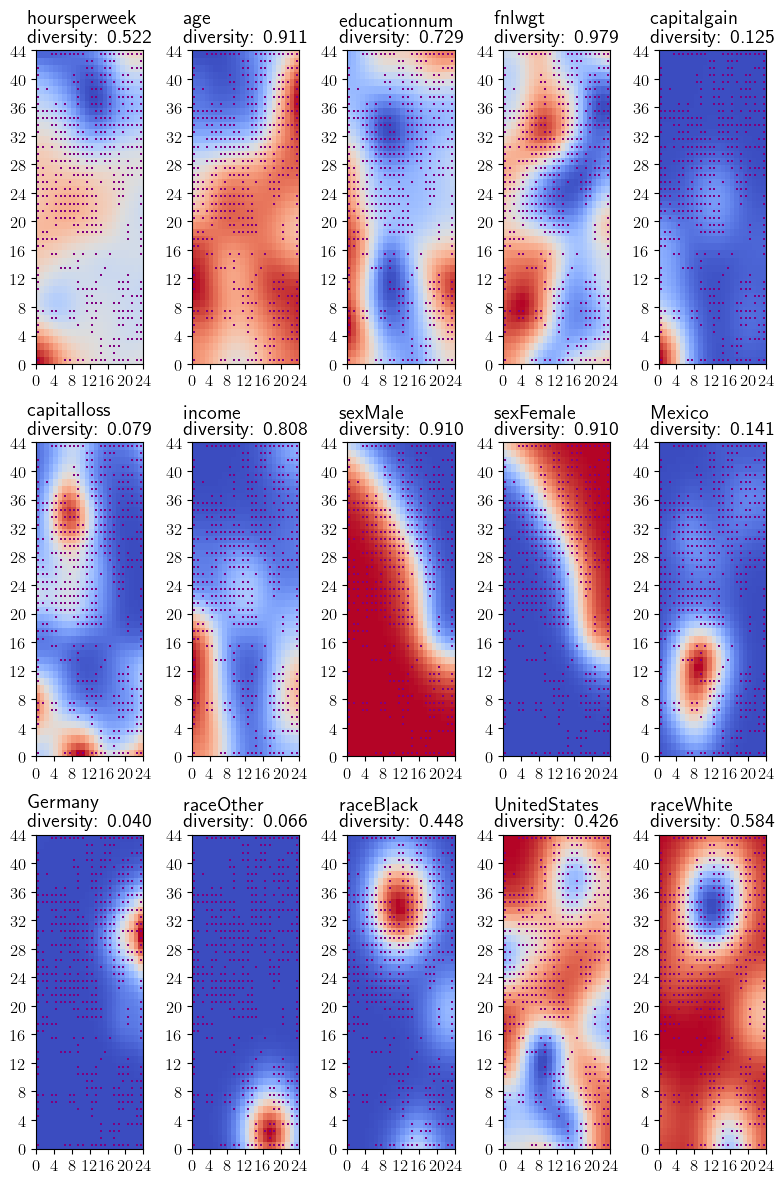

In [31]:
winners = [som.winner(xx) for cnt, xx in enumerate(X[:5000])] 

interesting_columns = ['age', 'educationnum', 'capitalgain', 'capitalloss',
 'hoursperweek', 'income', 'race_Black',
 'race_Other', 'race_White', 'sex_Female', 'sex_Male', 
 'nativecountry_UnitedStates', 'nativecountry_Mexico', 'nativecountry_Germany', 'fnlwgt']

cols = 5
rows = 3

plt.figure(figsize=(8, 12))

count = 1
for component in visited:
    feature = adult_dataset.columns[component] 
    if feature not in interesting_columns:
        continue
        
    title = feature
    if '_' in title:
        if 'country' in title:
            title = title.split('_')[-1]
        else:
            title = title.replace('_', '')
    
    diversity = util.shannon_diversity(adult_dataset[feature].value_counts().values)
    title = f'{title}\ndiversity: {diversity:.3f}'
    
    plt.subplot(rows, cols, count)
    plt.title(title)
    
    plt.pcolor(W[:,:,component].T, cmap='coolwarm')

    # palce a marker on bmu positions
    for w in winners:
        plt.plot(w[0]+.5, w[1]+.5, 's', markerfacecolor='purple', markersize=2, markeredgewidth=0)
   
    plt.xticks(np.arange(0, map_size[0]+1, 4))
    plt.yticks(np.arange(0, map_size[1]+1, 4))
    
    count += 1
    if count >= cols * rows + 1:
        break

plt.tight_layout()

# set the spacing between subplots
plt.subplots_adjust(wspace=0.45, 
                    hspace=0.25)

plt.savefig("figures/adult_components.pdf", dpi=300, format='pdf', bbox_inches='tight')
plt.savefig("figures/adult_components.png", dpi=300, format='png', bbox_inches='tight')

/tmp/ipykernel_26614/9204173.py:18: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(rows, cols, i+1)


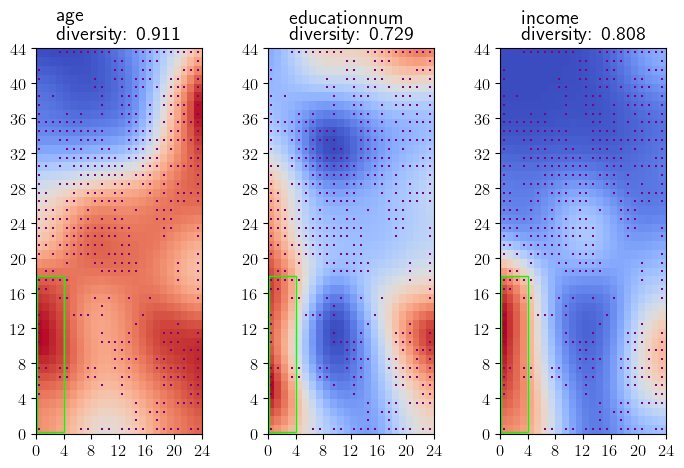

In [35]:
region = RegionOfInterest(x_lower=0.2, x_upper=5, y_lower=0.2, y_upper=18)

winners = [som.winner(xx) for cnt, xx in enumerate(X[:5000])] 
W = som.get_weights()

selected_columns = ['age', 'educationnum', 'income']

cols = 3
rows = 2

plt.figure(figsize=(7, 10))
plt.grid(visible=False)

for i, col in enumerate(selected_columns):
    index = adult_dataset.columns.to_list().index(col) 
    diversity = util.shannon_diversity(adult_dataset[col].value_counts().values)
    title = f'{col}\ndiversity: {diversity:.3f}'
    ax = plt.subplot(rows, cols, i+1)
    plt.title(title)
    plt.pcolor(W[:,:,index].T, cmap='coolwarm')
    
    for w in winners:
        # palce a marker on the winning position for the sample xx
        plt.plot(w[0]+.5, w[1]+.5, 's', markerfacecolor='purple', markersize=2, markeredgewidth=0)
        
    ax.add_patch(region.get_plt_rectangle())

    plt.xticks(np.arange(0, map_size[0]+1, 4))
    plt.yticks(np.arange(0, map_size[1]+1, 4))
    
plt.tight_layout()
# set the spacing between subplots
plt.subplots_adjust(wspace=0.4, 
                    hspace=0.4)

plt.savefig("figures/adult_correlated_components_region.pdf", dpi=300, format='pdf', bbox_inches='tight')
plt.savefig("figures/adult_correlated_components_region.png", dpi=300, format='png', bbox_inches='tight')